In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
import optuna
from plotly.io import show

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split 

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [2]:
train = pd.read_csv('dataset_citrus/train.csv')
test = pd.read_csv('dataset_citrus/test.csv')
y_true = pd.read_csv('dataset_citrus/test_Y_true.csv')

train['name'] = np.where(train['name']=='grapefruit',0,1)
y_true = np.where(y_true =='grapefruit',0,1).reshape(-1)
train.head()

,name,diameter,weight,red,green,blue
0,0,11.60,199.71,153,59,16
1,0,10.25,178.06,148,54,14
2,0,11.99,205.39,133,72,2
3,1,7.63,139.91,152,82,2
4,1,7.43,137.10,158,78,3


In [3]:
X, y = train.drop(['name'],axis=1), train['name']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [21]:
def objective(trial):
    # Препроцессинг
    ## Список скалеров в препроцессинге
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'normalizer', 'none'])

    ## Определение скалеров
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == "robust":
        scaler = RobustScaler()
    elif scalers == "normalizer":
        scaler = Normalizer()
    else:
        scaler = 'passthrough'

    # Определяем модель машинного обучения
    ## количество соседей
    knn_n_neighbors=trial.suggest_int("knn_n_neighbors", 1, 50, step=1) 
    ## степень метрики миньковского
    knn_p = trial.suggest_int("knn_p", 1, 10, step=1)
    ## влияние растояния
    knn_weights=trial.suggest_categorical("knn_weights", ['uniform', 'distance'])

    estimator=KNeighborsClassifier(n_neighbors=knn_n_neighbors, p = knn_p, weights=knn_weights)

    # Собираем контейнер
    pipeline = make_pipeline(scaler, estimator)

    # Вычисляем средний результат на кроссвалидации
    cv_score = cross_val_score(pipeline, X, y, cv=7)
    score_mean = cv_score.mean()
    score_std = cv_score.std()
    return score_mean
    
study = optuna.create_study(direction = "maximize") 
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-02-19 14:27:30,546] A new study created in memory with name: no-name-3ce4b172-12a5-445a-bd4b-81bb44ad2e94


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-02-19 14:27:31,123] Trial 0 finished with value: 0.922398810270377 and parameters: {'scalers': 'standard', 'knn_n_neighbors': 7, 'knn_p': 5, 'knn_weights': 'uniform'}. Best is trial 0 with value: 0.922398810270377.
[I 2025-02-19 14:27:31,333] Trial 1 finished with value: 0.919996978891059 and parameters: {'scalers': 'normalizer', 'knn_n_neighbors': 8, 'knn_p': 3, 'knn_weights': 'distance'}. Best is trial 0 with value: 0.922398810270377.
[I 2025-02-19 14:27:31,908] Trial 2 finished with value: 0.9265319311804324 and parameters: {'scalers': 'minmax', 'knn_n_neighbors': 36, 'knn_p': 3, 'knn_weights': 'distance'}. Best is trial 2 with value: 0.9265319311804324.
[I 2025-02-19 14:27:32,737] Trial 3 finished with value: 0.9229314860272468 and parameters: {'scalers': 'none', 'knn_n_neighbors': 49, 'knn_p': 7, 'knn_weights': 'uniform'}. Best is trial 2 with value: 0.9265319311804324.
[I 2025-02-19 14:27:33,567] Trial 4 finished with value: 0.9259982600005178 and parameters: {'scalers': 

In [22]:
print("Trial with highest accuracy: ")
print(f"\tnumber: {study.best_trial.number}")
print(f"\tparams: {study.best_trial.params}")
print(f"\tvalues: {study.best_trial.values}")

Trial with highest accuracy: 
	number: 44
	params: {'scalers': 'normalizer', 'knn_n_neighbors': 49, 'knn_p': 9, 'knn_weights': 'distance'}
	values: [0.9286648739097629]


In [23]:
study.best_trial.distributions

{'scalers': CategoricalDistribution(choices=('minmax', 'standard', 'robust', 'normalizer', 'none')),
 'knn_n_neighbors': IntDistribution(high=50, log=False, low=1, step=1),
 'knn_p': IntDistribution(high=10, log=False, low=1, step=1),
 'knn_weights': CategoricalDistribution(choices=('uniform', 'distance'))}

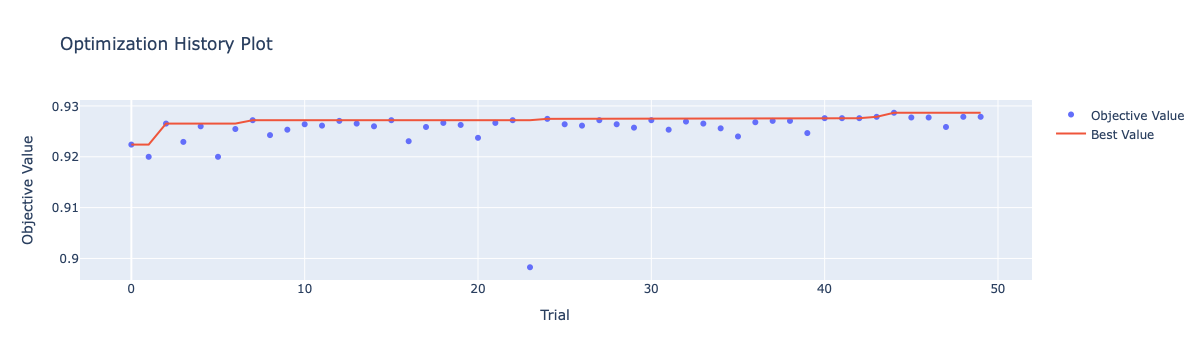

In [24]:
optuna.visualization.plot_optimization_history(study)

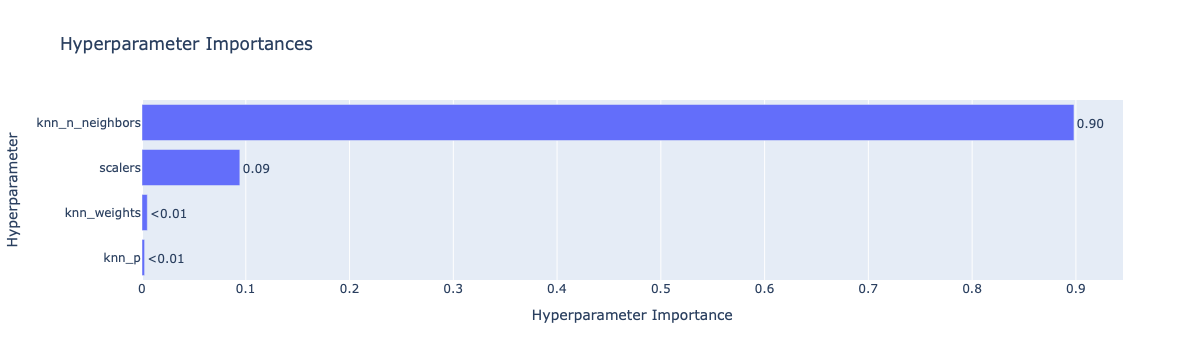

In [25]:
optuna.visualization.plot_param_importances(study)

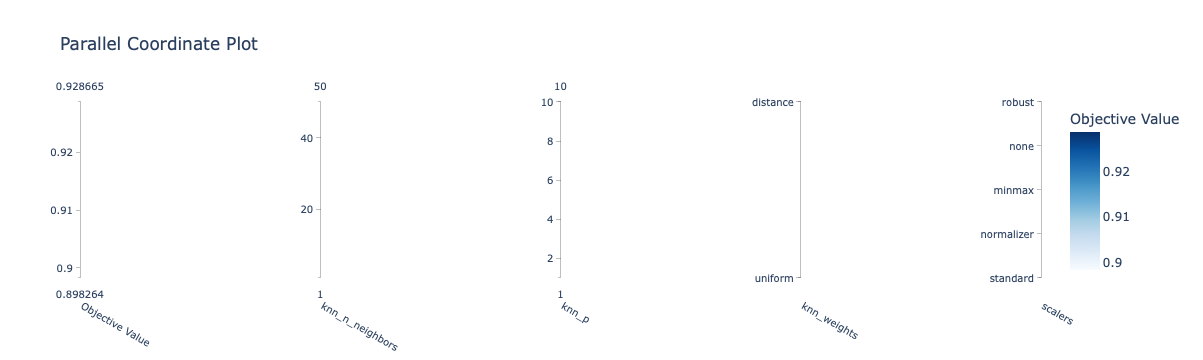

In [26]:
optuna.visualization.plot_parallel_coordinate(study)

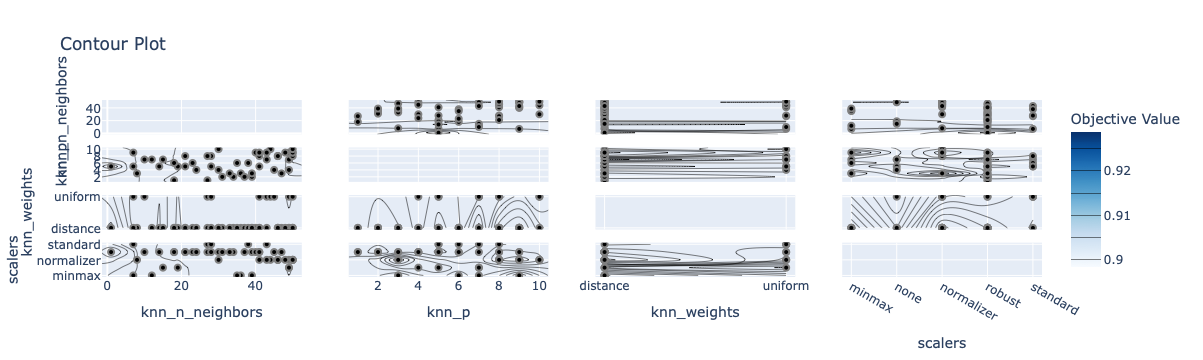

In [27]:
optuna.visualization.plot_contour(study)

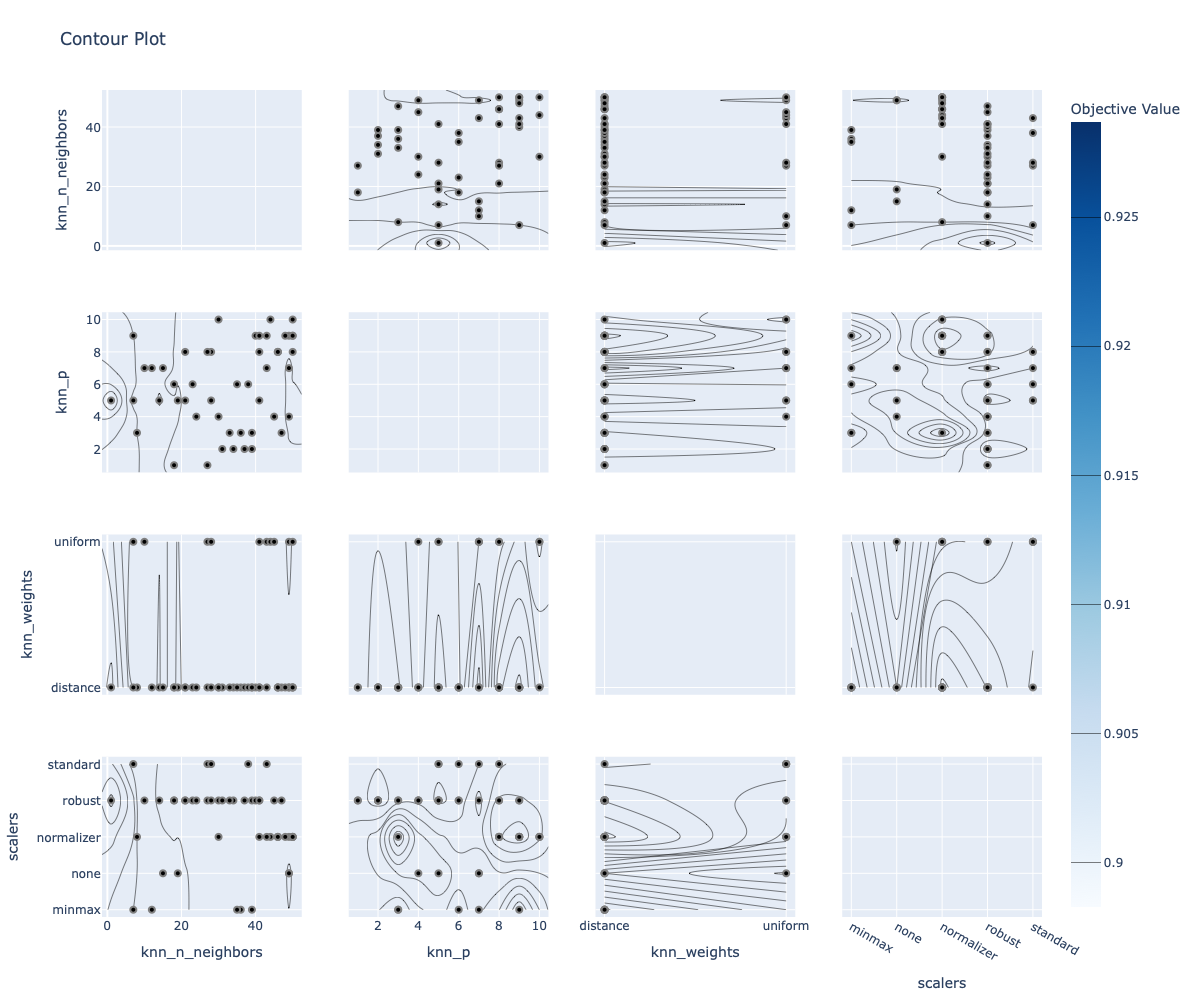

In [28]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=65, r=50, b=65, t=90))

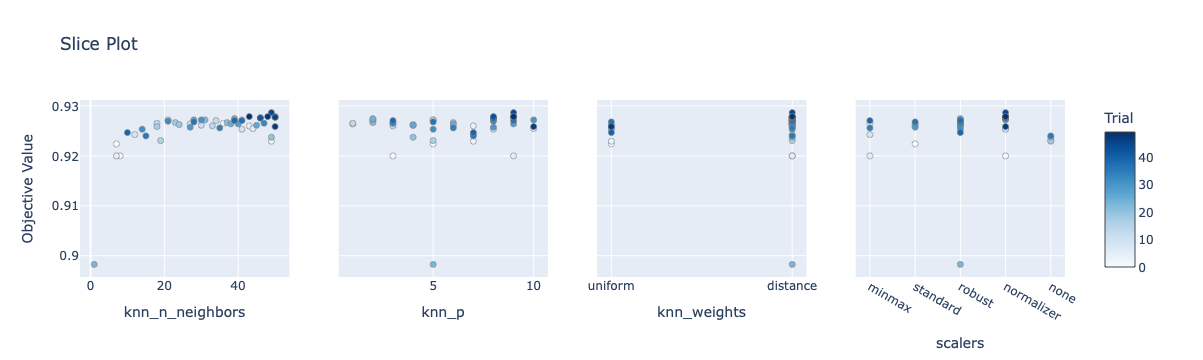

In [29]:
optuna.visualization.plot_slice(study)

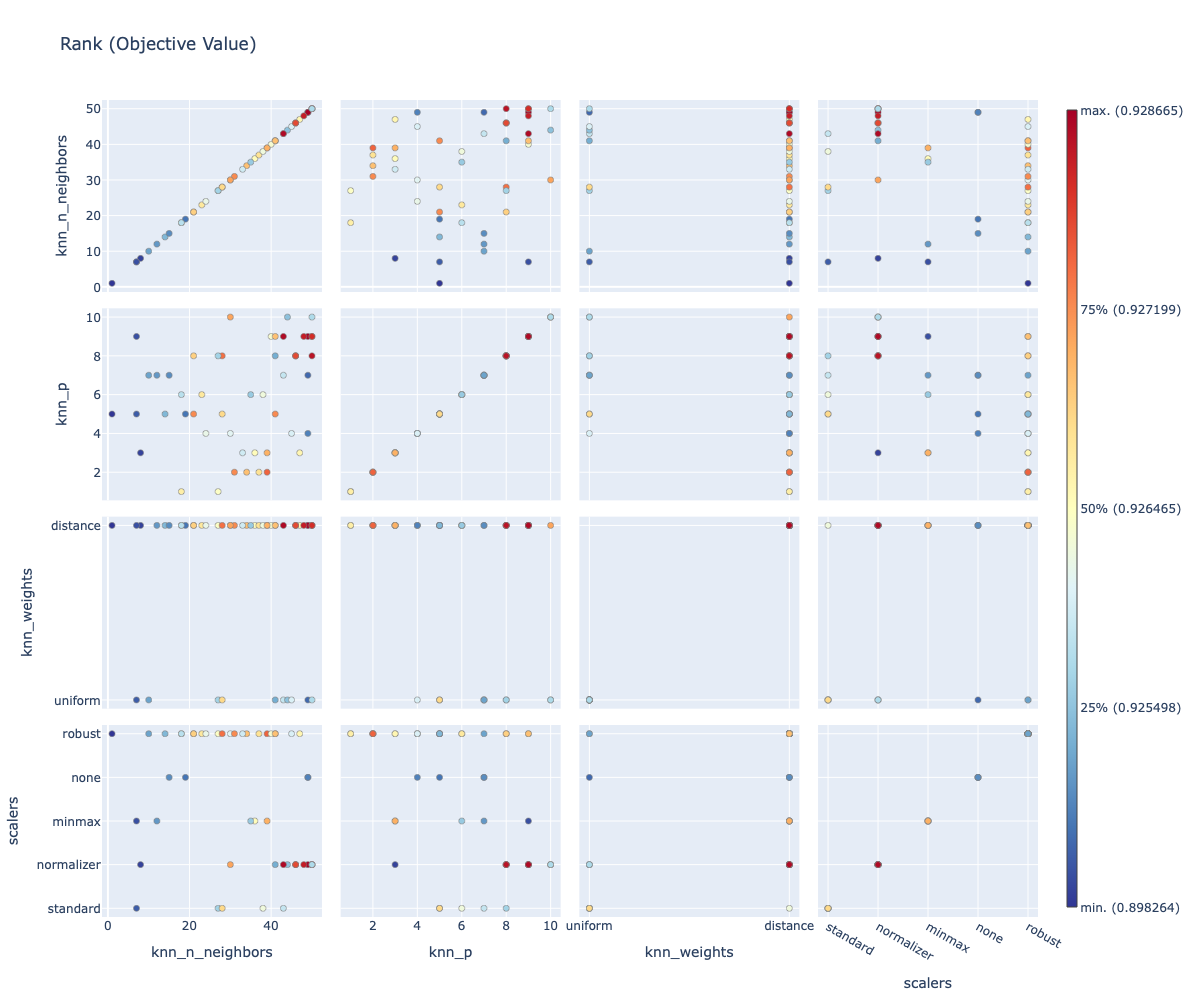

In [30]:
fig = optuna.visualization.plot_rank(study)
fig.update_layout(autosize=False,
                  width=1000, height=1000)

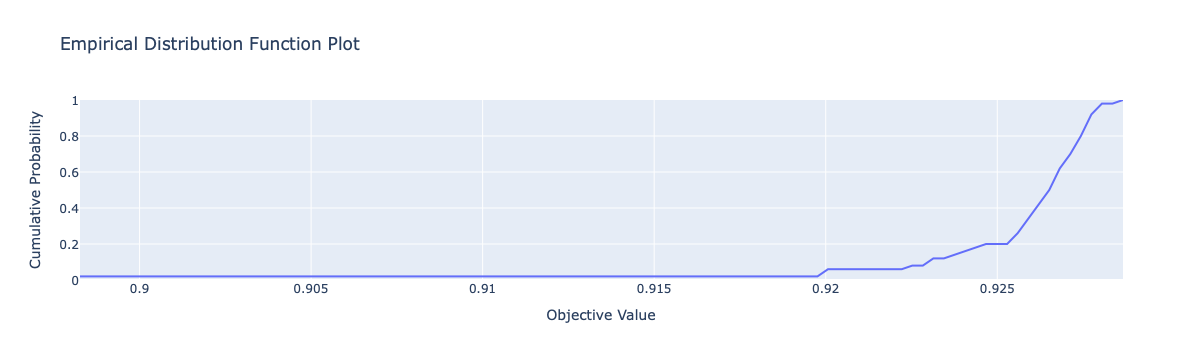

In [31]:
optuna.visualization.plot_edf(study)

In [32]:
study.best_trial.params

{'scalers': 'normalizer',
 'knn_n_neighbors': 49,
 'knn_p': 9,
 'knn_weights': 'distance'}

accuracy model train: 1.0
accuracy model test: 0.9285333333333333
accuracy true: 0.924


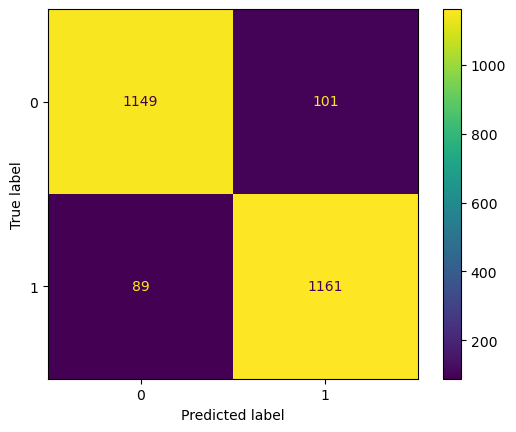

In [33]:
est_acr = KNeighborsClassifier(n_neighbors=49, p = 9, weights='distance')
pipeline = make_pipeline(Normalizer(), est_acr)
pipeline.fit(X_train, y_train)
print('accuracy model train:', pipeline.score(X_train, y_train))
print('accuracy model test:' , pipeline.score(X_test, y_test))
pipeline.fit(X, y)
y_predict = pipeline.predict(test)
print('accuracy true:', accuracy_score(y_true, y_predict))
ConfusionMatrixDisplay.from_predictions(y_true, y_predict);

In [34]:
def objective(trial):
    # Препроцессинг
    ## Список скалеров в препроцессинге
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'normalizer', 'none'])

    ## Определение скалеров
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == "robust":
        scaler = RobustScaler()
    elif scalers == "normalizer":
        scaler = Normalizer()
    else:
        scaler = 'passthrough'

    # Определяем модель машинного обучения
    ## количество соседей
    knn_n_neighbors=trial.suggest_int("knn_n_neighbors", 1, 50, step=1) 
    ## степень метрики миньковского
    knn_p = trial.suggest_int("knn_p", 1, 10, step=1)
    ## влияние растояния
    knn_weights=trial.suggest_categorical("knn_weights", ['uniform', 'distance'])

    estimator=KNeighborsClassifier(n_neighbors=knn_n_neighbors, p = knn_p, weights=knn_weights)

    # Собираем контейнер
    pipeline = make_pipeline(scaler, estimator)

    # Вычисляем средний результат на кроссвалидации
    cv_score = cross_val_score(pipeline, X, y, cv=7)
    score_mean = cv_score.mean()
    score_std = cv_score.std()
    return score_std
    
study = optuna.create_study(direction = "minimize") 
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-02-19 14:29:24,769] A new study created in memory with name: no-name-22485615-3834-44f7-b42f-f52b6a6a5572


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-02-19 14:29:25,856] Trial 0 finished with value: 0.005350474456864426 and parameters: {'scalers': 'standard', 'knn_n_neighbors': 12, 'knn_p': 8, 'knn_weights': 'uniform'}. Best is trial 0 with value: 0.005350474456864426.
[I 2025-02-19 14:29:26,588] Trial 1 finished with value: 0.006663011102552327 and parameters: {'scalers': 'minmax', 'knn_n_neighbors': 1, 'knn_p': 3, 'knn_weights': 'uniform'}. Best is trial 0 with value: 0.005350474456864426.
[I 2025-02-19 14:29:27,169] Trial 2 finished with value: 0.005094098776744917 and parameters: {'scalers': 'minmax', 'knn_n_neighbors': 39, 'knn_p': 4, 'knn_weights': 'distance'}. Best is trial 2 with value: 0.005094098776744917.
[I 2025-02-19 14:29:27,621] Trial 3 finished with value: 0.0069864453934319806 and parameters: {'scalers': 'minmax', 'knn_n_neighbors': 39, 'knn_p': 2, 'knn_weights': 'uniform'}. Best is trial 2 with value: 0.005094098776744917.
[I 2025-02-19 14:29:28,025] Trial 4 finished with value: 0.00552344437401746 and para

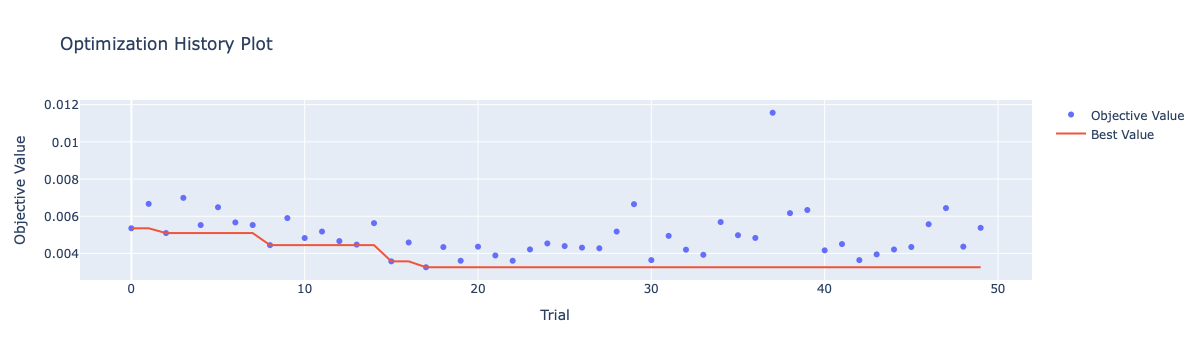

In [35]:
optuna.visualization.plot_optimization_history(study)

In [36]:
study.best_trial.params

{'scalers': 'normalizer',
 'knn_n_neighbors': 33,
 'knn_p': 7,
 'knn_weights': 'distance'}

accuracy model train: 1.0
accuracy model test: 0.9274666666666667
accuracy true: 0.9212


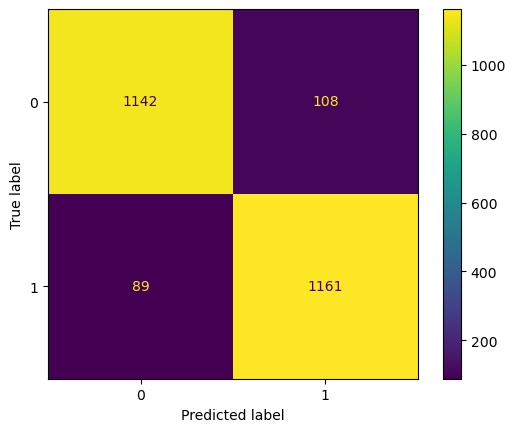

In [38]:
est_std = KNeighborsClassifier(n_neighbors=33, p = 7, weights='distance')
pipeline = make_pipeline(RobustScaler(), est_std)
pipeline.fit(X_train, y_train)
print('accuracy model train:', pipeline.score(X_train, y_train))
print('accuracy model test:' , pipeline.score(X_test, y_test))
pipeline.fit(X, y)
y_predict = pipeline.predict(test)
print('accuracy true:', accuracy_score(y_true, y_predict))
ConfusionMatrixDisplay.from_predictions(y_true, y_predict);